In [2]:
# %reset -f

In [3]:
import os
import pandas as pd
from itertools import groupby, count
from aqi_engine import calculate_aqi, fill_missing_with_average

In [4]:
# The raw data folder path
folder_path = "data/delhi_all_stations_hourly_2010_2023/"

# Get all files in the folder that start with "DL" (represents Delhi) and have the extension ".csv"
# file_names = [file for file in os.listdir(folder_path) if file.startswith("DL") and file.endswith(".csv")]
file_names = ["DL022", "DL038", "DL035", "DL024", "DL033", "DL007", "DL023", "DL031", "DL036", "DL014", "DL037", "DL040", "DL029", "DL039", "DL025", "DL019", "DL034", "DL028", "DL011", "DL016", "DL030", "DL004", "DL021", "DL026", "DL027"]

# Initialize an empty DataFrame
data_df = [] # pd.DataFrame()

# Loop through the file names and append the data to the DataFrame
for file_name in file_names:
    file_path = os.path.join(folder_path, file_name + ".csv")
    # Read the CSV and create the StationId column with the filename
    data = pd.read_csv(file_path)
    # Strip out the file extension ".csv" from file_name before updating "StationId" column
    data['StationId'] = os.path.splitext(file_name)[0]
    data_df.append(data)

df = pd.concat(data_df)

del data
del data_df
del file_name
del file_names
del file_path
del folder_path

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1356484 entries, 0 to 45229
Data columns (total 53 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   From Date            1356484 non-null  object 
 1   To Date              1356484 non-null  object 
 2   PM2.5 (ug/m3)        1038796 non-null  float64
 3   PM10 (ug/m3)         987482 non-null   float64
 4   NO (ug/m3)           1051725 non-null  float64
 5   NO2 (ug/m3)          1067280 non-null  float64
 6   NOx (ppb)            974320 non-null   float64
 7   NH3 (ug/m3)          870425 non-null   float64
 8   SO2 (ug/m3)          914764 non-null   float64
 9   CO (mg/m3)           957384 non-null   float64
 10  Ozone (ug/m3)        1066942 non-null  float64
 11  Benzene (ug/m3)      770476 non-null   float64
 12  Toluene (ug/m3)      798136 non-null   float64
 13  Temp (degree C)      120873 non-null   float64
 14  RH (%)               938383 non-null   float64
 15  WS (m

In [5]:
# Drop "To Date" column
df = df.drop(columns='To Date')
# Rename "From Date" as "Datetime"
df = df.rename(columns={'From Date': 'Datetime'})
# Convert "Datetime" as datetime datatype
df['Datetime'] = pd.to_datetime(df['Datetime'])

In [6]:
# Filter records created on or after 2021-12-28
df = df[df['Datetime'] >= '2020-11-28']
# Reset the index
df = df.reset_index(drop=True)

df.head()

,Datetime,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NOx (ppb),NH3 (ug/m3),SO2 (ug/m3),CO (mg/m3),Ozone (ug/m3),...,NMHC (ug/m3),SPM (ug/m3),THC (ug/m3),RH (),BP (),CH4 (),NOx (ug/m3),WD (degree C),Gust (m/s),CO (ng/m3)
0,2020-11-28 00:00:00,110.25,180.25,6.83,47.30,30.75,31.32,5.92,1.45,13.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-11-28 01:00:00,128.25,200.25,5.63,46.60,29.37,33.10,5.67,1.30,11.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-11-28 02:00:00,147.25,208.50,3.60,41.45,25.05,31.95,7.50,1.10,15.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-11-28 03:00:00,158.50,222.50,4.32,37.15,23.30,28.75,8.12,1.05,20.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-11-28 04:00:00,162.75,220.00,4.48,39.75,24.77,28.22,7.78,1.40,17.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# VERIFY MISSING HOURLY RECORD IN EVERY STATION
#========================================================================
# Generate a reference date range with hourly intervals
reference_range = pd.date_range(start=df['Datetime'].min(), end=df['Datetime'].max(), freq='H')

# Group by 'StationId' and check for missing dates in each group
missing_records = df.groupby('StationId')['Datetime'].apply(lambda x: reference_range.difference(x))

# Filter out stations with no missing records
stations_with_missing_records = missing_records[missing_records.apply(lambda x: len(x) > 0)]

# Print result to check for any missing dates
print(stations_with_missing_records)

Series([], Name: Datetime, dtype: object)


In [8]:
# Few columns are similar, so merge them
column_mapping = {
    "CO (ug/m3)":        ["CO (mg/m3)", "CO (ng/m3)"],
    "Xylene (ug/m3)":    ["Xylene ()", "MP-Xylene (ug/m3)"],
    "MP-Xylene (ug/m3)": ["MP-Xylene ()"],
    "Benzene (ug/m3)":   ["Benzene ()"],
    "Toluene (ug/m3)":   ["Toluene ()"],
    "SO2 (ug/m3)":       ["SO2 ()"],
    "NOx (ug/m3)":       ["NOx (ppb)"],
    # "Ozone (ug/m3)":     ["Ozone (ppb)"],
    "AT (degree C)":     ["AT ()", "Temp (degree C)"],
    "WD (degree)":       ["WD (degree C)", "WD (deg)", "WD ()"],
    # "WS (m/s)":          ["WS ()"]
}

# Fill missing values in the new column
for new_column, old_columns in column_mapping.items():
    for old_column in old_columns:
        df[new_column] = df[new_column].combine_first(df[old_column])

# Drop duplicate columns
df = df.drop(columns=sum(column_mapping.values(), []))

In [9]:
# DROP COLUMNS WITH MORE THAN 50% MISSING RECORDS
#========================================================================
# Calculate the percentage of missing values for each column
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Select columns with 50% or more missing values
columns_with_50_percent_missing = missing_percentage[missing_percentage >= 50].index.tolist()

print(columns_with_50_percent_missing)

# Drop columns with 50% or more missing values
df = df.drop(columns=columns_with_50_percent_missing)

['VWS (m/s)', 'Eth-Benzene ()', 'Temp (ug/m3)', 'Eth-Benzene (ug/m3)', 'Gust (km/hr)', 'Variance (n)', 'Power (W)', 'CO2 (mg/m3)', 'Xylene (ug/m3)', 'O Xylene (ug/m3)', 'CH4 (ug/m3)', 'NMHC (ug/m3)', 'SPM (ug/m3)', 'THC (ug/m3)', 'RH ()', 'BP ()', 'CH4 ()', 'Gust (m/s)']


In [10]:
df = calculate_aqi(df)

In [11]:
ROLLING_HOURS = 3

df = fill_missing_with_average(df, ROLLING_HOURS, ['PM2.5 (ug/m3)'])
df = calculate_aqi(df)

df = fill_missing_with_average(df, ROLLING_HOURS, ['PM10 (ug/m3)'])
df = calculate_aqi(df)

df = fill_missing_with_average(df, ROLLING_HOURS, ['SO2 (ug/m3)'])
df = calculate_aqi(df)

df = fill_missing_with_average(df, ROLLING_HOURS, ['NOx (ug/m3)'])
df = calculate_aqi(df)

df = fill_missing_with_average(df, ROLLING_HOURS, ['NH3 (ug/m3)'])
df = calculate_aqi(df)

df = fill_missing_with_average(df, ROLLING_HOURS, ['CO (ug/m3)'])
df = calculate_aqi(df)

df = fill_missing_with_average(df, ROLLING_HOURS, ['Ozone (ug/m3)'])
df = calculate_aqi(df)

In [12]:
# Get all columns except datetime stationid
non_AQI_related_columns = df.drop(['Datetime', 'StationId', 'AQI', 'PM2.5 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)', 'NOx (ug/m3)', 'NH3 (ug/m3)', 'CO (ug/m3)', 'Ozone (ug/m3)'], axis=1).columns.tolist()

df = fill_missing_with_average(df, ROLLING_HOURS, non_AQI_related_columns)

In [13]:
reamining_missing_columns = ['NO2 (ug/m3)', 'PM10 (ug/m3)', 'SO2 (ug/m3)']
ROLLING_HOURS = 24

df = fill_missing_with_average(df, ROLLING_HOURS, reamining_missing_columns)

In [14]:
# Sort by Stations before exporting the data for EDA
df = df.sort_values(by=['StationId', 'Datetime'])

# Reset the index of the DataFrame
df = df.reset_index(drop=True)

# Fill missing values in 'RF (mm)' column with a default value of 0
df['RF (mm)'] = df['RF (mm)'].fillna(0)

In [15]:
# Get all columns except datetime stationid
all_columns_except_datetime_stationid = df.drop(['Datetime', 'StationId'], axis=1).columns.tolist()

# Filter DataFrame where AQI is missing
# df_missing_aqi = df[df["AQI"].isnull()]

# Get missing value count for each column in the filtered DataFrame
missing_value_counts = df[all_columns_except_datetime_stationid].isnull().sum()

# Order the records by missing value count in descending order
missing_value_counts = missing_value_counts.sort_values(ascending=True)

print(missing_value_counts)

PM2.5 (ug/m3)        0
CO (ug/m3)           0
RF (mm)              0
AT (degree C)        0
SR (W/mt2)           0
WD (degree)          0
WS (m/s)             0
NOx (ug/m3)          0
RH (%)               0
Benzene (ug/m3)      0
Ozone (ug/m3)        0
SO2 (ug/m3)          0
NH3 (ug/m3)          0
NO2 (ug/m3)          0
NO (ug/m3)           0
PM10 (ug/m3)         0
Toluene (ug/m3)      0
BP (mmHg)            3
AQI                375
dtype: int64


In [16]:
df.head()

,Datetime,PM2.5 (ug/m3),PM10 (ug/m3),NO (ug/m3),NO2 (ug/m3),NH3 (ug/m3),SO2 (ug/m3),Ozone (ug/m3),Benzene (ug/m3),Toluene (ug/m3),...,WS (m/s),WD (degree),SR (W/mt2),BP (mmHg),AT (degree C),RF (mm),StationId,CO (ug/m3),NOx (ug/m3),AQI
0,2020-11-28 00:00:00,68.850000,242.810000,18.430000,39.450000,63.330000,7.770000,12.240000,1.350000,3.180000,...,0.250000,218.980000,4.380000,NaN,14.740000,0.0,DL004,0.440000,35.730000,NaN
1,2020-11-28 01:00:00,116.314167,196.385993,21.800417,47.558600,38.778182,9.790615,7.173750,3.729500,25.674762,...,0.800000,217.970909,5.183810,981.320556,17.485455,0.0,DL004,1.106522,48.732917,NaN
2,2020-11-28 02:00:00,118.085745,196.181544,21.502340,49.366855,38.363488,10.031594,7.075455,3.822368,25.430000,...,0.830976,209.814186,5.178049,981.070556,17.294884,0.0,DL004,1.106522,48.110000,NaN
3,2020-11-28 03:00:00,121.146667,195.504038,18.938358,49.432938,37.339508,10.039609,7.796061,3.757143,23.730169,...,0.900167,210.963016,5.129167,980.915556,17.177302,0.0,DL004,1.083125,44.364478,NaN
4,2020-11-28 04:00:00,126.420870,194.864346,15.099394,48.631877,36.644667,9.976959,10.230455,3.468364,20.480172,...,0.992500,207.958254,5.031167,980.621111,16.844286,0.0,DL004,1.011250,38.598788,NaN


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512400 entries, 0 to 512399
Data columns (total 21 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Datetime         512400 non-null  datetime64[ns]
 1   PM2.5 (ug/m3)    512400 non-null  float64       
 2   PM10 (ug/m3)     512400 non-null  float64       
 3   NO (ug/m3)       512400 non-null  float64       
 4   NO2 (ug/m3)      512400 non-null  float64       
 5   NH3 (ug/m3)      512400 non-null  float64       
 6   SO2 (ug/m3)      512400 non-null  float64       
 7   Ozone (ug/m3)    512400 non-null  float64       
 8   Benzene (ug/m3)  512400 non-null  float64       
 9   Toluene (ug/m3)  512400 non-null  float64       
 10  RH (%)           512400 non-null  float64       
 11  WS (m/s)         512400 non-null  float64       
 12  WD (degree)      512400 non-null  float64       
 13  SR (W/mt2)       512400 non-null  float64       
 14  BP (mmHg)        512

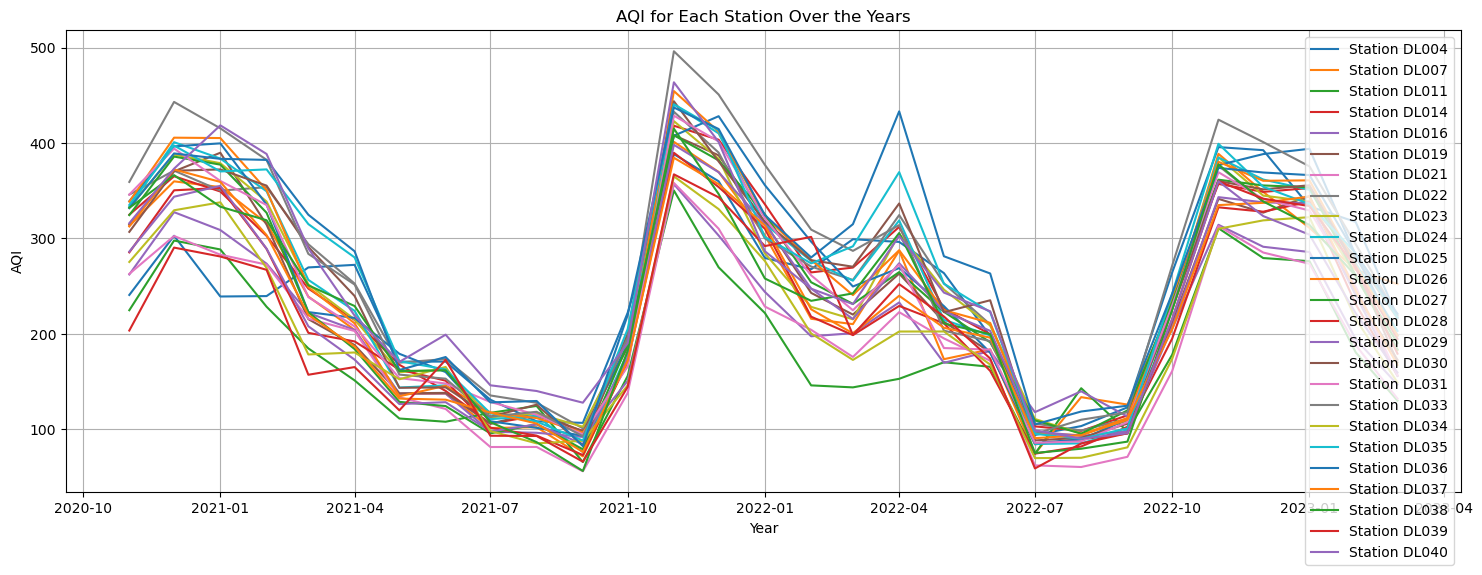

In [18]:
import matplotlib.pyplot as plt

chart_df = df.copy()

column_name = 'AQI'

# Create 'Year_Month' column with the 1st day of every month
chart_df['YearMonth'] = chart_df['Datetime'].dt.to_period('M').dt.to_timestamp()

station_level_chart_df = chart_df.groupby(['StationId', 'YearMonth'])[column_name].mean().reset_index()

# Create a line chart for each StationId
plt.figure(figsize=(18, 6))

# Plot AQI for each station over the years
for station_id in station_level_chart_df['StationId'].unique():
    station_data = station_level_chart_df[station_level_chart_df['StationId'] == station_id]
    plt.plot(station_data['YearMonth'], station_data[column_name], label=f'Station {station_id}')

# Customize the plot
plt.title('AQI for Each Station Over the Years')
plt.xlabel('Year')
plt.ylabel('AQI')
plt.legend()
plt.grid(True)
plt.show()

In [1]:
# Columns to keep
selected_columns = ["Datetime", "StationId", "PM2.5 (ug/m3)", "PM10 (ug/m3)", "NO (ug/m3)", "NO2 (ug/m3)", "NOx (ug/m3)", "NH3 (ug/m3)", "SO2 (ug/m3)", "CO (ug/m3)", "Ozone (ug/m3)", "Benzene (ug/m3)", "Toluene (ug/m3)", "RH (%)", "WS (m/s)", "WD (degree)", "BP (mmHg)", "AT (degree C)", "RF (mm)", "SR (W/mt2)", "AQI"]

# TODO: Make sure to create 'generated' folder if not exists

# Save the DataFrame to a CSV file with selected columns
df[selected_columns].to_csv('data/generated/delhi_stations_hourly.csv', index=False)

NameError: name 'df' is not defined